# Micrograd: An Autograd Engine from Scratch

In this notebook we explore **micrograd** — a minimal automatic differentiation engine that implements backpropagation (reverse-mode autodiff) over a dynamically built computational graph. It operates on scalar values, but implements the exact same algorithm that PyTorch uses over tensors.

We'll:
1. Build simple expressions and compute gradients automatically
2. Verify our gradients match PyTorch's autograd
3. Build a small neural network (MLP) from the primitives
4. Train it on a toy binary classification task (make_moons)
5. Visualize the learned decision boundary

## Section 1: The Value Class — Building a Computational Graph

The `Value` class wraps a scalar and tracks every operation performed on it, building a directed acyclic graph (DAG). When we call `.backward()`, it walks this graph in reverse topological order, applying the chain rule at each node to compute gradients.

In [1]:
from foundations.micrograd.engine import Value

a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a * b + c
print(d)  # Value(data=4.0, grad=0)

Value(data=4.0, grad=0)


In [2]:
d.backward()
print(f"a.grad = {a.grad}")  # dd/da = b = -3.0
print(f"b.grad = {b.grad}")  # dd/db = a = 2.0
print(f"c.grad = {c.grad}")  # dd/dc = 1.0

a.grad = -3.0
b.grad = 2.0
c.grad = 1


In [3]:
import torch

a_pt = torch.tensor([2.0], requires_grad=True)
b_pt = torch.tensor([-3.0], requires_grad=True)
c_pt = torch.tensor([10.0], requires_grad=True)
d_pt = a_pt * b_pt + c_pt
d_pt.backward()

print(f"PyTorch: a.grad={a_pt.grad.item()}, b.grad={b_pt.grad.item()}, c.grad={c_pt.grad.item()}")
assert a.grad == a_pt.grad.item()
assert b.grad == b_pt.grad.item()
assert c.grad == c_pt.grad.item()
print("Gradients match PyTorch!")

PyTorch: a.grad=-3.0, b.grad=2.0, c.grad=1.0
Gradients match PyTorch!


What just happened:
- The expression `d = a * b + c` built a computational graph: `a` and `b` feed into a multiply node, whose output and `c` feed into an add node producing `d`.
- `d.backward()` set `d.grad = 1` (the derivative of `d` with respect to itself), then walked backward through the graph applying the chain rule at each operation.
- For the add node: both inputs get `out.grad` passed through (derivative of addition is 1).
- For the multiply node: `a.grad = b.data * out.grad = -3.0`, `b.grad = a.data * out.grad = 2.0`.
- These match PyTorch exactly — because it's the same algorithm, just operating on scalars instead of tensors.

## Section 2: A More Complex Expression

Let's test `tanh`, `**`, and `/` — and verify against PyTorch again.

In [ ]:
x = Value(2.0)
y = (x**2 + Value(3.0) * x).tanh()
y.backward()
print(f"x = {x.data}, y = {y.data:.6f}, dy/dx = {x.grad:.6f}")

In [ ]:
# Verify against PyTorch
x_pt = torch.tensor([2.0], dtype=torch.float64, requires_grad=True)
y_pt = (x_pt**2 + 3.0 * x_pt).tanh()
y_pt.backward()

print(f"PyTorch: y = {y_pt.item():.6f}, dy/dx = {x_pt.grad.item():.6f}")
assert abs(y.data - y_pt.item()) < 1e-6
assert abs(x.grad - x_pt.grad.item()) < 1e-6
print("Gradients match PyTorch!")

**A note on gradient accumulation**: Notice that in `backward()`, we use `+=` (not `=`) when accumulating gradients. This is critical for correctness — if a value is used in multiple operations (e.g., `x + x`), it receives gradient contributions from each use, and these must be summed.

## Section 3: Neural Network Primitives

With the autograd engine in place, we can build neural network layers as thin wrappers. A `Neuron` computes a weighted sum of inputs plus bias, then applies an activation. A `Layer` is a collection of neurons, and an `MLP` is a stack of layers.

In [4]:
from foundations.micrograd.nn import Neuron, Layer, MLP

# A single neuron with 3 inputs
n = Neuron(3)
x = [Value(1.0), Value(2.0), Value(3.0)]
print(f"Neuron output: {n(x)}")
print(f"Neuron parameters: {len(n.parameters())}")  # 3 weights + 1 bias = 4

# A full MLP: 3 inputs -> 4 hidden -> 4 hidden -> 1 output
model = MLP(3, [4, 4, 1])
print(f"MLP output: {model(x)}")
print(f"Total parameters: {len(model.parameters())}")  # (3*4+4) + (4*4+4) + (4*1+1) = 41

Neuron output: Value(data=0, grad=0)
Neuron parameters: 4
MLP output: Value(data=2.624527762676022, grad=0)
Total parameters: 41


The architecture `MLP(3, [4, 4, 1])` creates:
- Layer 1: 3 inputs → 4 neurons (ReLU activation) = 3×4 + 4 = 16 parameters
- Layer 2: 4 inputs → 4 neurons (ReLU activation) = 4×4 + 4 = 20 parameters  
- Layer 3: 4 inputs → 1 neuron (linear, no activation) = 4×1 + 1 = 5 parameters
- **Total: 41 parameters**

The last layer is linear (no activation) because it produces the raw output score for classification.

## Section 4: Training on make_moons

Now let's put it all together. We'll generate a toy 2D binary classification dataset (two interleaving half-circles), train an MLP to separate them, and visualize the learned decision boundary.

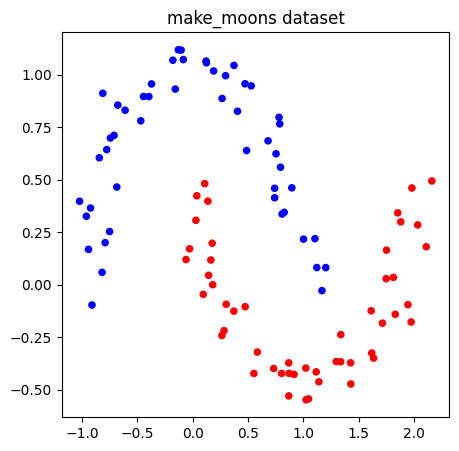

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

np.random.seed(1337)
X, y = make_moons(n_samples=100, noise=0.1)
y = y * 2 - 1  # convert to -1, +1 labels

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20)
plt.title('make_moons dataset')
plt.show()

In [7]:
model = MLP(2, [16, 16, 1])
print(f"Number of parameters: {len(model.parameters())}")

Number of parameters: 337


In [8]:
for k in range(100):
    # Forward pass: compute predictions
    ypred = [model(x) for x in X]

    # Hinge loss (SVM max-margin loss)
    losses = [(1 + -yi*ypred_i).relu() for yi, ypred_i in zip(y, ypred)]
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum(p*p for p in model.parameters())
    total_loss = data_loss + reg_loss

    # Accuracy
    accuracy = [(yi > 0) == (ypred_i.data > 0) for yi, ypred_i in zip(y, ypred)]
    acc = sum(accuracy) / len(accuracy)

    # Backward pass
    model.zero_grad()
    total_loss.backward()

    # SGD update
    learning_rate = 1.0 - 0.9 * k / 100  # learning rate decay
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 10 == 0:
        print(f"step {k:3d} loss {total_loss.data:.4f}, accuracy {acc*100:.1f}%")

print(f"\nFinal: loss {total_loss.data:.4f}, accuracy {acc*100:.1f}%")
assert acc > 0.9, f"Expected >90% accuracy, got {acc*100:.1f}%"

step   0 loss 1.6372, accuracy 22.0%
step  10 loss 0.1985, accuracy 91.0%
step  20 loss 0.1282, accuracy 95.0%
step  30 loss 0.1268, accuracy 95.0%
step  40 loss 0.0209, accuracy 100.0%
step  50 loss 0.0142, accuracy 100.0%
step  60 loss 0.0130, accuracy 100.0%
step  70 loss 0.0127, accuracy 100.0%
step  80 loss 0.0115, accuracy 100.0%
step  90 loss 0.0123, accuracy 100.0%

Final: loss 0.0115, accuracy 100.0%


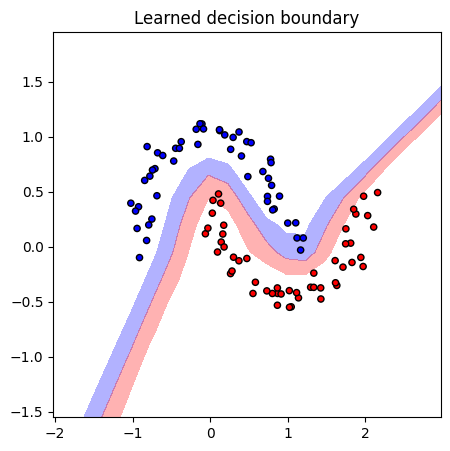

In [9]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
scores = [model(x).data for x in Xmesh]
Z = np.array(scores).reshape(xx.shape)

plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.3, colors=['blue', 'red'])
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=20, edgecolors='k')
plt.title('Learned decision boundary')
plt.show()

## Summary

We built a complete autograd engine and neural network library from scratch:

- The **`Value` class** builds a computational graph during the forward pass and traverses it in reverse for backpropagation. This is the same algorithm PyTorch uses — just over scalars instead of tensors.
- The **chain rule** is applied locally at each node — this is the only calculus needed for training neural networks.
- The neural network layers (`Neuron`, `Layer`, `MLP`) are thin wrappers — the real work is in the autograd engine.
- We trained an MLP on a toy classification task using **hinge loss** and **SGD**, achieving >90% accuracy.

Everything we build from here — the MLP in Chapter 3, the GPT in Chapter 4+ — uses the same gradient-based training loop, just with PyTorch tensors instead of our scalar `Value` objects.